In [1]:
import os

import sys
os.chdir("/Users/zyxu/Documents/py/kris")
import numpy as np
import pandas as pd
import h5py
import hdf5plugin

import func.prepro as pp
import gc

# visualizations
import plotly.express as px
import plotly.offline as pyo
import plotly
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import seaborn as sns
import matplotlib.pyplot as plt

custom_colors = ["#a8e6cf","#dcedc1","#ffd3b6","#ffaaa5","#ff8b94"]
palette = sns.set_palette(sns.color_palette(custom_colors))

In [2]:
DATA_DIR = "open-problems-multimodal"
FP_CELL_METADATA = os.path.join(DATA_DIR,"metadata.csv")

FP_CITE_TRAIN_INPUTS = os.path.join(DATA_DIR,"train_cite_inputs.h5")
FP_CITE_TRAIN_TARGETS = os.path.join(DATA_DIR,"train_cite_targets.h5")
FP_CITE_TEST_INPUTS = os.path.join(DATA_DIR,"test_cite_inputs.h5")

FP_MULTIOME_TRAIN_INPUTS = os.path.join(DATA_DIR,"train_multi_inputs.h5")
FP_MULTIOME_TRAIN_TARGETS = os.path.join(DATA_DIR,"train_multi_targets.h5")
FP_MULTIOME_TEST_INPUTS = os.path.join(DATA_DIR,"test_multi_inputs.h5")

FP_SUBMISSION = os.path.join(DATA_DIR,"sample_submission.csv")
FP_EVALUATION_IDS = os.path.join(DATA_DIR,"evaluation_ids.csv")

In [3]:
train_multi_inputs = pp.readH5pyFile(FP_MULTIOME_TRAIN_INPUTS)
train_multi_targets = pp.readH5pyFile(FP_MULTIOME_TRAIN_TARGETS)
# test_multi_inputs = readH5pyFile(FP_MULTIOME_TEST_INPUTS)

In [4]:
train_cite_inputs = pp.readH5pyFile(FP_CITE_TRAIN_INPUTS)
train_cite_targets = pp.readH5pyFile(FP_CITE_TRAIN_TARGETS)
# test_cite_inputs = pp.readH5pyFile(FP_CITE_TEST_INPUTS)

In [5]:
for key, val in train_cite_inputs.items():
    print(f"{key} shape is {val.shape}")

axis0 shape is (22050,)
axis1 shape is (70988,)
block0_items shape is (22050,)
block0_values shape is (70988, 22050)


In [32]:
train_cite_targets['axis0'].astype(str)[:10]

array(['CD86', 'CD274', 'CD270', 'CD155', 'CD112', 'CD47', 'CD48', 'CD40',
       'CD154', 'CD52'], dtype='<U11')

In [7]:
train_RNA = pd.DataFrame(train_cite_inputs['block0_values'])
train_RNA.shape

(70988, 22050)

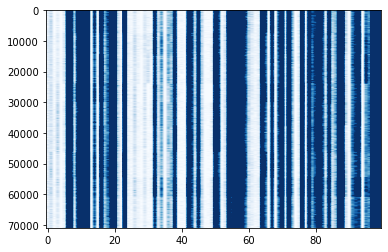

In [15]:
plt.imshow(train_RNA.iloc[:,:100], cmap='Blues', aspect='auto', vmin=0, vmax=1)

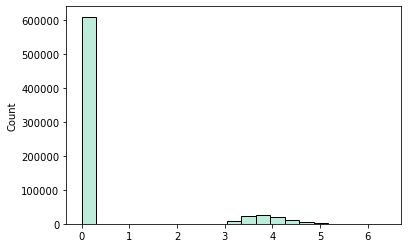

In [7]:
sns.histplot(data=train_RNA.values[:,:10].reshape(-1))

### group mean

In [8]:
protein = train_cite_targets['axis0'].astype(str)
RNA = train_multi_targets['axis0'].astype(str)

In [40]:
Y_mean_train_cite = train_cite_targets['block0_values'].sum(0)/len(protein)

In [47]:
dict_target_protein = dict(map(lambda k: (k[1], Y_mean_train_cite[k[0]]), enumerate(protein)))

In [27]:
Y_mean_train_multi = np.array([train_multi_targets['block0_values'][i:i+1000].sum(0) for i in range(0,len(RNA),1000)]).sum(0)/len(RNA)
Y_mean_train_multi

array([0.6115092 , 0.33865315, 0.17515817, ..., 1.1683866 , 1.1548035 ,
       2.0399148 ], dtype=float32)

In [30]:
dict_target_RNA = dict(map(lambda k: (k[1], Y_mean_train_multi[k[0]]), enumerate(RNA)))

In [ ]:
DIR = 'open-problems-multimodal/'

list_ct_protein = h5py.File(DIR+'train_cite_targets.h5')['train_cite_targets']['axis0'][:].astype(str)
list_mt_RNA = h5py.File(DIR+'train_multi_targets.h5')['train_multi_targets']['axis0'][:].astype(str)

Y_mean_cite = np.sum([h5py.File(DIR+'train_cite_targets.h5')['train_cite_targets']['block0_values'][i:i+500].sum(axis=0) 
                      for i in range(0, len(list_ct_protein), 500)], axis=0)/len(list_ct_protein)
Y_mean_multi = np.sum([h5py.File(DIR+'train_multi_targets.h5')['train_multi_targets']['block0_values'][i:i+500].sum(axis=0) 
                       for i in range(0, len(list_mt_RNA), 500)], axis=0)/len(list_mt_RNA)

# dict_target = dict(map(lambda _:(_[1], Y_mean_cite[_[0]]), enumerate(list_ct_protein)))
# dict_target.update(map(lambda _:(_[1], Y_mean_multi[_[0]]), enumerate(list_mt_RNA)))

# pd.DataFrame(columns=['target']).rename_axis('row_id').to_csv('submission_mean_target.csv')
# with pd.read_csv(DIR+'evaluation_ids.csv', dtype="str", usecols=['cell_id', 'gene_id'], chunksize=1000000) as reader:
#     for chunk in reader:
#         chunk.assign(target=chunk.gene_id.apply(lambda _:dict_target[_])).rename_axis('row_id')['target']\
#         .to_csv('submission_mean_target.csv', float_format='%.2f', header=False, mode='a')

In [34]:
# kmeans
from sklearn.cluster import KMeans

In [42]:
km = KMeans(
    init="random",
    n_clusters= 10,
    n_init=10,
    max_iter=300,
    random_state=42
    )

In [43]:
km.fit(train_cite_targets['block0_values'])

KMeans(init='random', n_clusters=3, random_state=42)

In [46]:
km.labels_[:10]

array([2, 2, 0, 2, 0, 0, 2, 2, 2, 2], dtype=int32)

In [45]:
km.predict(train_cite_targets['block0_values'][:10])

array([2, 2, 0, 2, 0, 0, 2, 2, 2, 2], dtype=int32)

In [1]:
from sklearn.cluster import MiniBatchKMeans
km_multi = MiniBatchKMeans(
    init="random",
    n_clusters= 10,
    n_init=10,
    max_iter=300,
    random_state=42
    )

In [2]:
for i in range(train_multi_targets['block0_values'].shape[0],1000):
    km_multi.partial_fit(train_multi_targets['block0_values'][i:i+1000])

NameError: name 'train_multi_targets' is not defined

In [ ]:
km_multi.labels_[:10]

In [ ]:
km_multi.predict(train_multi_targets['block0_values'][:10])